<a href="https://colab.research.google.com/github/ebinjomonkottakal/Tensorflow_advanced/blob/main/Saliency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# grab the model from Tensorflow hub and append a softmax activation
model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'),
    tf.keras.layers.Activation('softmax')
])

# build the model on a specified batch input shape
model.build([None,300,300,3])

In [3]:
!wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

--2023-05-10 14:35:23--  https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.14.16, 104.18.15.16, 2606:4700::6812:e10, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.14.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 212830 (208K) [binary/octet-stream]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 207.84K  --.-KB/s    in 0.02s   

2023-05-10 14:35:24 (11.5 MB/s) - ‘image.jpg’ saved [212830/212830]



In [4]:
img = cv2.imread('image.jpg')
# format it to be in the RGB colorspace
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize(img,(300,300))/255.0
# add a batch dimension in front
image = np.expand_dims(img,axis=0)

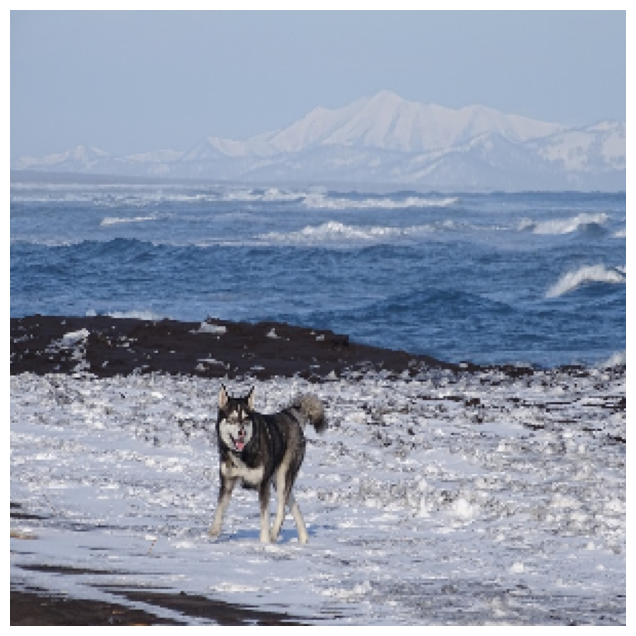

In [5]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

# Compute gradients

In [6]:
# Siberian Husky's class ID in ImageNet
class_index = 251

# number of classes
num_classes = 1001

# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index]*image.shape[0],num_classes)
with tf.GradientTape() as tape:
    # cast image to float
    inputs = tf.cast(image, tf.float32)

    # watch the input pixels
    tape.watch(inputs)

    # generate the predictions
    predictions = model(inputs)

    # get the loss
    loss = tf.keras.losses.categorical_crossentropy(
        expected_output, predictions
    )

# get the gradient with respect to the inputs
gradients = tape.gradient(loss, inputs)

In [10]:
# reduce the RGB image to grayscale
grayscale_tensor = tf.reduce_sum(tf.abs(gradients),axis = -1)
# normalize the pixel values to be in the range [0, 255].
# the max value in the grayscale tensor will be pushed to 255.
# the min value will be pushed to 0.
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

# remove the channel dimension to make the tensor a 2d tensor
normalized_tensor = tf.squeeze(normalized_tensor)

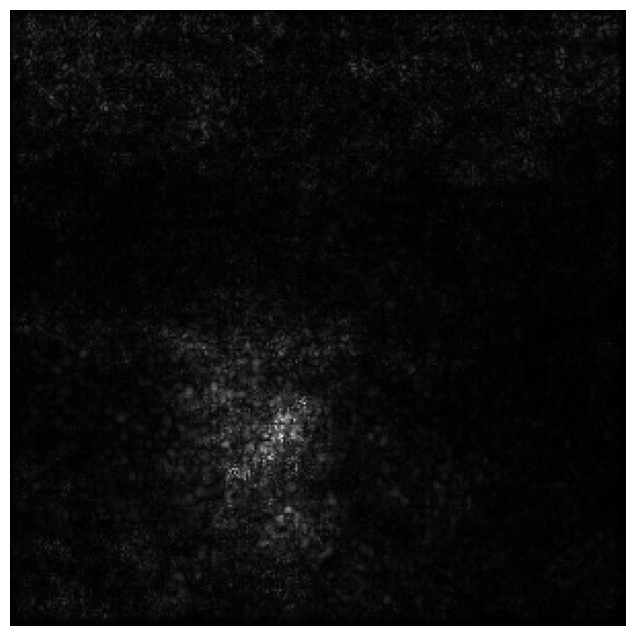

In [13]:
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(normalized_tensor,cmap='gray')
plt.show()

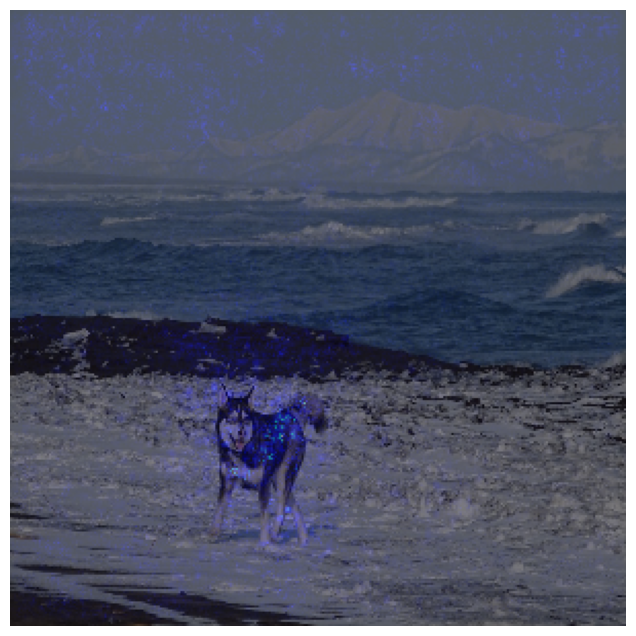

In [14]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(),cv2.COLORMAP_HOT)
gradient_color = gradient_color/255.0
super_imposed = cv2.addWeighted(img,0.5,gradient_color,0.5,0.0)
plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()